1. 데이터 준비   
 1.1 csv데이터   


In [1]:
# PATH변경
%cd "/content/drive/MyDrive/Colab Notebooks"

import pandas as pd
label_df = pd.read_csv('Dataset/train.csv')
label_df.head()

/content/drive/MyDrive/Colab Notebooks


,file_name,label
0,001.PNG,9
1,002.PNG,4
2,003.PNG,1
3,004.PNG,1
4,005.PNG,6


 1.2 이미지 데이터

In [2]:
import os
from glob import glob

def get_train_data(data_dir):
    img_path_list = []
    label_list = []

    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.PNG')))
    #print(glob(os.path.join(data_dir,'*.PNG')))
    # /로 짤린 것 중에서 맨 뒤( *.PNG) + 거기서 '.'으로 나뉘는 파일이름으로 정렬
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))

    # get label
    label_list.extend(label_df['label'])

    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []

    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.PNG')))
    img_path_list.sort(key=lambda x : int(x.split('/')[-1].split('.')[0]) )

    return img_path_list


2. 데이터 확인
 2. 1 csv 데이터

In [3]:
print(label_df.head())
label_df.info()


  file_name  label
0   001.PNG      9
1   002.PNG      4
2   003.PNG      1
3   004.PNG      1
4   005.PNG      6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  723 non-null    object
 1   label      723 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.4+ KB


   2.2 이미지 데이터

In [4]:
all_img_path, all_label = get_train_data('Dataset/train')
test_img_path = get_test_data('Dataset/test')
print(all_img_path[:5])
print(all_label[:5])

['Dataset/train/001.PNG', 'Dataset/train/002.PNG', 'Dataset/train/003.PNG', 'Dataset/train/004.PNG', 'Dataset/train/005.PNG']
[9, 4, 1, 1, 6]


3. 환경설정   
데이터를 전처리 하기 위한 GPU 환경설정

In [5]:
import torch
import torch.nn as nn
# 병렬화 비활성화
#os.environ["TOKENIZERS_PARALLELISM"] = "false"
# GPU를 정렬 , 0번 부터
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # Arrange GPU devices starting from 0
# 사용하고자 하는 GPU빼고 나머지 제한
#os.environ["CUDA_VISIBLE_DEVICES"] = "2" # Set the GPU 2 to us, multi gpu

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [6]:
# GPU 체크 및 할당
if torch.cuda.is_available():
    print('Device :',device)
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU :', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

Device : cuda
There are 1 GPU(s) available.
We will use the GPU : Tesla T4


데이터 전처리   
CustomDataset

In [7]:
import torchvision.datasets as datasets # 데이터셋 
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import Dataset

import cv2

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self,index):
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)
        
        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.img_path_list)

    

CustomDataset으로 만든 Data확인

In [8]:
temp_dataset = CustomDataset(all_img_path,all_label, train_mode=False)

<class 'numpy.ndarray'>


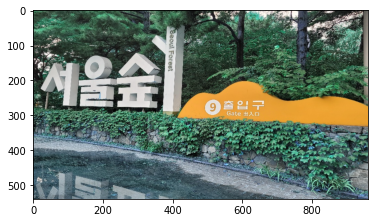

In [9]:
import matplotlib.pyplot as plt
print(type(temp_dataset.__getitem__(0)))
plt.imshow(temp_dataset.__getitem__(0))

전체 이미지 mean과 std 구하기

In [10]:
# 모든 이미지의 사이즈 확인
# mean과 std 구하기
import numpy as np
temp_transform = transforms.Compose([
    transforms.ToTensor(), # tensor로 변경
])
temp_dataset = CustomDataset(
    all_img_path,all_label, train_mode=False, transforms=temp_transform)

def find_info(dataset):
    img_size = []
    img_mean = np.empty((0,3))
    img_std = np.empty((0,3))
    #print(len(dataset)) -> 723개
    for i in range(len(dataset)):
        img = dataset.__getitem__(i)
        m = np.mean(np.array(img),axis=(1,2))
        s = np.std(np.array(img),axis=(1,2))
        img_mean = np.append(img_mean,[m],axis=0)
        img_std = np.append(img_std,[s],axis=0)
        #print(np.array(img).shape) # 3,540,960
        #print(img_mean.shape)      # (3,)
        #print(img_std.shape)       # (3,)

        if img.shape not in img_size:
            img_size.append(img.shape)
    #print(img_mean.shape)
    mean_r = np.mean(img_mean[:,0])
    mean_g = np.mean(img_mean[:,1])
    mean_b = np.mean(img_mean[:,2])
    mean = (mean_r, mean_g, mean_b)
    
    std_r = np.mean(img_std[:,0])
    std_g = np.mean(img_std[:,1])
    std_b = np.mean(img_std[:,2])
    std = (std_r,std_g,std_b)

    return img_size, mean, std

img_size, img_mean, img_std = find_info(temp_dataset)
print(f'img_size = {img_size}')
print(f'img mean = {img_mean}')
print(f'img std = {img_std}')


img_size = [torch.Size([3, 540, 960])]
img mean = (0.4748486610410289, 0.4787037393611496, 0.4584236602153356)
img std = (0.2947070961959794, 0.26378257766386615, 0.25401256951718576)


Train / Validation split   
전체 데이터에서 분리

In [11]:
train_len = int(len(all_img_path)*0.75)
val_len = int(len(all_img_path)*0.25)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

val_img_path = all_img_path[train_len:]
val_label = all_label[train_len:]

In [12]:
print(f'train set 크기 : {len(train_img_path)}')
print(f'val set 크기 : {len(val_img_path)}')

train set 크기 : 542
val set 크기 : 181


하이퍼 파라미터 값 설정

In [13]:
CFG = {
    'IMG_SIZE':512,
    'CROP_SIZE':384,
    'EPOCHS':200,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':8,
}

Transform

In [14]:
train_transform = transforms.Compose([
    transforms.ToPILImage(), # numpy --> PIL로 변경
    transforms.Resize([CFG['IMG_SIZE'],CFG['IMG_SIZE']]), #128 * 128이미지로 사이즈변경
    transforms.RandomCrop(CFG['CROP_SIZE']),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(), # tensor로 변경
    transforms.Normalize(mean=img_mean, std=img_std), # 이미지 정규화 
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([CFG['IMG_SIZE'],CFG['IMG_SIZE']]),
    transforms.RandomCrop(CFG['CROP_SIZE']),
    transforms.ToTensor(),
    transforms.Normalize(mean=img_mean, std=img_std),
])

DataLoader

In [15]:
train_dataset = CustomDataset(
    train_img_path, 
    train_label,
    train_mode=True,
    transforms=train_transform
    )
train_loader = DataLoader(
    train_dataset,
    batch_size = CFG['BATCH_SIZE'],
    shuffle=True,
    num_workers=0 # data로드를 위해 몇개의 서브 프로세스를 사용할지
)

val_dataset = CustomDataset(
    val_img_path,
    val_label,
    train_mode=True,
    transforms=test_transform
)
val_loader = DataLoader(
    val_dataset,
    batch_size = CFG['BATCH_SIZE'],
    shuffle=False,
    num_workers=0
)

In [16]:
train_batches = len(train_loader)
val_batches = len(val_loader)

print(f'total train imgs : {train_len} / total train batches :{train_batches}')
print(f'total val imgs : {val_len} / total val batches :{val_batches}')

total train imgs : 542 / total train batches :68
total val imgs : 180 / total val batches :23


Model 정의

In [17]:
from torchvision import models
from torchvision.models import efficientnet_b3 
import torch.nn as nn
from torch.nn import functional as F

model = models.efficientnet_b7(pretrained=True)
resnet101 = models.resnet101(pretrained=True)
resnet50 = models.resnet50(pretrained=True)
# 기본 모델은 fc 마지막이 1000개의 분류 , 맞춰주어야한다
print(model.classifier)
model.fc = nn.Linear(1000,10)
resnet101 = nn.Linear(1000,10)
resnet50 = nn.Linear(1000,10)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=1000, bias=True)
)


Model 학습

In [18]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=CFG['LEARNING_RATE'],momentum=0.9)
scheduler=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10,T_mult=2)

In [19]:
from tqdm import tqdm

def train(mdoel,optimizer, train_loader, scheduler,device):
    model.to(device)
    n = len(train_loader)
    best_acc = 0
    count = 0
    best_loss = 100
    history = {}
    history['train_loss'] =[]
    history['train_acc'] = []
    history['val_loss'] = []
    history['val_acc'] = []
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        running_loss = 0.0

        for img, label in tqdm(iter(train_loader)):
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()

            output = model(img)
            loss = criterion(output,label)

            loss.backward()
            optimizer.step()
            running_loss +=loss.item()
        print(f'{epoch} Train loss : {running_loss/len(train_loader):.5f}')

        if scheduler is not None:
            scheduler.step()

        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for img, label in tqdm(iter(val_loader)):
                img, label = img.to(device), label.to(device)

                output = model(img)
                val_loss += criterion(output,label)
                # 가장 높은 것을 예측
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(label.view_as(pred)).sum().item()
        val_acc = 100* correct / len(val_loader.dataset)
        print(f'Val loss : {val_loss/len(val_loader):.4f}, Acc : {correct}/{len(val_loader.dataset)} :{100*correct/len(val_loader.dataset):.1f}')
        history['train_loss'].append(running_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        # best 모델 저장
        #if best_acc < val_acc:
        #    best_acc = val_acc
        #    torch.save(model.state_dict(),'save_model/best_model.pth')
        #    print('Model Saved')
        # 5번 연속으로 개선이 없으면 멈추기
        if best_acc > val_acc:
            if count > 5:
                print('Early stopping')
                break
            count +=1
        else:
            best_acc = val_acc
            if best_loss > val_loss:
                torch.save(model.state_dict(),'save_model/best_model.pth')
                print('Model Saved')

                best_loss = val_loss
                count = 0
    return history

In [ ]:
print(os.getcwd())
print(os.path.isdir('save_model'))
history =train(model, optimizer, train_loader, scheduler, device)

/content/drive/MyDrive/Colab Notebooks
True


100%|██████████| 68/68 [01:11<00:00,  1.06s/it]


1 Train loss : 1.84293


100%|██████████| 23/23 [00:09<00:00,  2.38it/s]


Val loss : 0.6087, Acc : 158/181 :87.3
Model Saved


100%|██████████| 68/68 [01:10<00:00,  1.03s/it]


2 Train loss : 0.16655


100%|██████████| 23/23 [00:09<00:00,  2.39it/s]


Val loss : 0.2009, Acc : 174/181 :96.1
Model Saved


100%|██████████| 68/68 [01:10<00:00,  1.04s/it]


3 Train loss : 0.10018


100%|██████████| 23/23 [00:09<00:00,  2.38it/s]


Val loss : 0.1116, Acc : 177/181 :97.8
Model Saved


100%|██████████| 68/68 [01:10<00:00,  1.04s/it]


4 Train loss : 0.04588


100%|██████████| 23/23 [00:09<00:00,  2.37it/s]


Val loss : 0.0616, Acc : 180/181 :99.4
Model Saved


100%|██████████| 68/68 [01:10<00:00,  1.04s/it]


5 Train loss : 0.03898


100%|██████████| 23/23 [00:09<00:00,  2.38it/s]


Val loss : 0.0529, Acc : 180/181 :99.4
Model Saved


100%|██████████| 68/68 [01:10<00:00,  1.04s/it]


6 Train loss : 0.01519


100%|██████████| 23/23 [00:09<00:00,  2.38it/s]


Val loss : 0.0751, Acc : 178/181 :98.3


100%|██████████| 68/68 [01:10<00:00,  1.04s/it]


7 Train loss : 0.02357


100%|██████████| 23/23 [00:09<00:00,  2.38it/s]


Val loss : 0.0585, Acc : 180/181 :99.4


100%|██████████| 68/68 [01:10<00:00,  1.04s/it]


8 Train loss : 0.01192


100%|██████████| 23/23 [00:09<00:00,  2.37it/s]


Val loss : 0.0457, Acc : 179/181 :98.9


100%|██████████| 68/68 [01:10<00:00,  1.04s/it]


9 Train loss : 0.00699


100%|██████████| 23/23 [00:09<00:00,  2.37it/s]


Val loss : 0.0428, Acc : 179/181 :98.9


100%|██████████| 68/68 [01:10<00:00,  1.04s/it]


10 Train loss : 0.01823


100%|██████████| 23/23 [00:09<00:00,  2.37it/s]


Val loss : 0.0486, Acc : 178/181 :98.3


100%|██████████| 68/68 [01:11<00:00,  1.05s/it]


11 Train loss : 0.03268


100%|██████████| 23/23 [00:09<00:00,  2.39it/s]


Val loss : 0.0561, Acc : 178/181 :98.3


100%|██████████| 68/68 [01:17<00:00,  1.14s/it]


12 Train loss : 0.04390


100%|██████████| 23/23 [00:09<00:00,  2.36it/s]


Val loss : 0.0412, Acc : 180/181 :99.4
Model Saved


100%|██████████| 68/68 [01:11<00:00,  1.06s/it]


13 Train loss : 0.06822


100%|██████████| 23/23 [00:12<00:00,  1.83it/s]


Val loss : 0.0408, Acc : 179/181 :98.9


100%|██████████| 68/68 [01:13<00:00,  1.08s/it]


14 Train loss : 0.04195


100%|██████████| 23/23 [00:09<00:00,  2.35it/s]


Val loss : 0.0272, Acc : 180/181 :99.4
Model Saved


100%|██████████| 68/68 [01:14<00:00,  1.09s/it]


15 Train loss : 0.04255


100%|██████████| 23/23 [00:09<00:00,  2.36it/s]


Val loss : 0.0242, Acc : 180/181 :99.4
Model Saved


100%|██████████| 68/68 [01:12<00:00,  1.06s/it]


16 Train loss : 0.01277


100%|██████████| 23/23 [00:09<00:00,  2.36it/s]


Val loss : 0.0256, Acc : 180/181 :99.4


100%|██████████| 68/68 [01:12<00:00,  1.07s/it]


17 Train loss : 0.02696


100%|██████████| 23/23 [00:09<00:00,  2.35it/s]


Val loss : 0.0389, Acc : 179/181 :98.9


100%|██████████| 68/68 [01:11<00:00,  1.06s/it]


18 Train loss : 0.01710


100%|██████████| 23/23 [00:09<00:00,  2.37it/s]


Val loss : 0.0308, Acc : 180/181 :99.4


100%|██████████| 68/68 [01:11<00:00,  1.06s/it]


19 Train loss : 0.01783


100%|██████████| 23/23 [00:09<00:00,  2.35it/s]


Val loss : 0.0493, Acc : 178/181 :98.3


100%|██████████| 68/68 [01:11<00:00,  1.06s/it]


20 Train loss : 0.01041


100%|██████████| 23/23 [00:09<00:00,  2.37it/s]


Val loss : 0.0202, Acc : 180/181 :99.4
Model Saved


100%|██████████| 68/68 [01:11<00:00,  1.06s/it]


21 Train loss : 0.00778


100%|██████████| 23/23 [00:10<00:00,  2.23it/s]


Val loss : 0.0423, Acc : 180/181 :99.4


100%|██████████| 68/68 [01:12<00:00,  1.07s/it]


22 Train loss : 0.00739


100%|██████████| 23/23 [00:09<00:00,  2.36it/s]


Val loss : 0.0312, Acc : 180/181 :99.4


100%|██████████| 68/68 [01:11<00:00,  1.06s/it]


23 Train loss : 0.01698


100%|██████████| 23/23 [00:09<00:00,  2.35it/s]


Val loss : 0.0367, Acc : 179/181 :98.9


100%|██████████| 68/68 [01:12<00:00,  1.06s/it]


24 Train loss : 0.00552


100%|██████████| 23/23 [00:09<00:00,  2.35it/s]


Val loss : 0.0330, Acc : 180/181 :99.4


100%|██████████| 68/68 [01:11<00:00,  1.06s/it]


25 Train loss : 0.00719


100%|██████████| 23/23 [00:09<00:00,  2.36it/s]


Val loss : 0.0308, Acc : 180/181 :99.4


 38%|███▊      | 26/68 [00:28<00:48,  1.15s/it]

예측하기

In [ ]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.to(device)

            pred_output = model(img)
            pred_output = pred_output.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_output.tolist())
    return model_pred

In [ ]:
test_dataset = CustomDataset(test_img_path,None,train_mode=False,transforms=test_transform)
test_loader= DataLoader(test_dataset,batch_size =CFG['BATCH_SIZE'],shuffle=False,num_workers=0)

checkpoint = torch.load('save_model/best_model.pth')
model.load_state_dict(checkpoint)

preds = predict(model,test_loader,device)
preds[0:5]

submission 파일 생성

In [ ]:
submission = pd.read_csv('Dataset/sample_submission.csv')
submission['label'] = preds
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/save_model/submission_efficient.csv',index=False)